In [7]:
import pandas as pd
import yfinance as yf
import datetime

# 데이터 불러오기
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 12, 27)
btc_data = yf.download('BTC-USD', start=start, end=end)

# 필요한 컬럼 선택
btc_data = btc_data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_data)

# 학습 데이터 생성
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# 데이터 차원 변환 [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# 모델 생성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X, y, epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0306
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0011
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 8.8728e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 7.5314e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 6.5600e-04
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 7.2731e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0012
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 5.8935e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 5.5497e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 6.8534e-04
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0011
Epoch 13/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 4.4845e-04
Epoch 14/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 4.9068e-04
Epoch 15/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms

In [11]:
# 예측 데이터 생성
train_size = int(len(scaled_data) * 0.8)
test_data = scaled_data[train_size - time_step:]

X_test, y_test = create_dataset(test_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


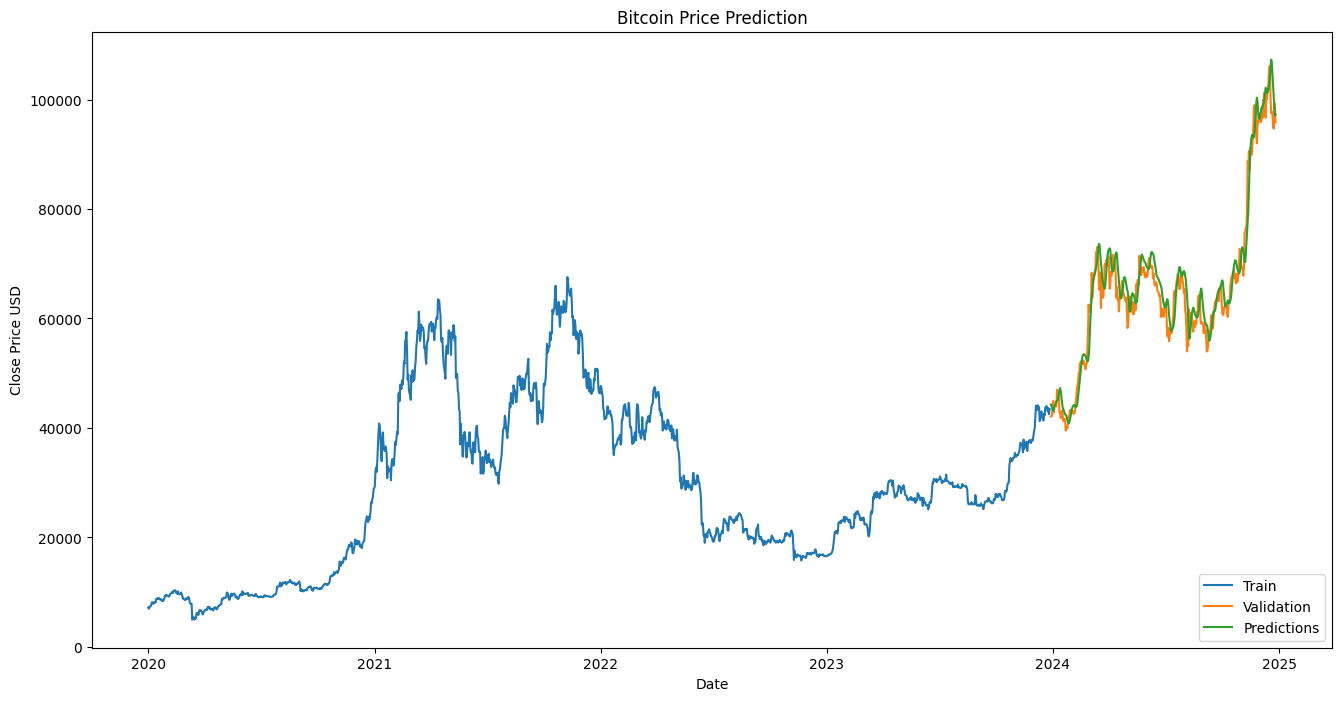

In [17]:
# 시각화
import matplotlib.pyplot as plt

train = btc_data[:train_size]
valid = btc_data[train_size:]

# 길이 맞추기
min_len = min(len(valid), len(predictions))  # 최소 길이 계산
valid = valid.iloc[-min_len:]  # valid를 최소 길이에 맞춰 슬라이싱
predictions = predictions[-min_len:]  # predictions도 최소 길이에 맞춰 슬라이싱

# Predictions 열 추가
valid['Predictions'] = predictions


# 시각화
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Validation')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()


In [19]:
# 예측 데이터와 실제 데이터만 출력
predicted_dates = valid.index  # 예측에 사용된 날짜
predicted_values = valid['Predictions'].values.flatten()  # 1차원으로 변환
actual_values = valid['Close'].values.flatten()  # 1차원으로 변환

# DataFrame으로 정리
results = pd.DataFrame({
    'Date': predicted_dates,
    'Actual': actual_values,
    'Predicted': predicted_values
})

print(results)


          Date        Actual      Predicted
0   2023-12-29  42099.402344   44277.058594
1   2023-12-30  42156.902344   44040.906250
2   2023-12-31  42265.187500   43689.511719
3   2024-01-01  44167.332031   43362.476562
4   2024-01-02  44957.968750   43132.671875
..         ...           ...            ...
359 2024-12-22  95104.937500  102448.296875
360 2024-12-23  94686.242188  100527.335938
361 2024-12-24  98676.093750   98625.726562
362 2024-12-25  99299.195312   97114.164062
363 2024-12-26  95795.515625   97247.304688

[364 rows x 3 columns]
